In [15]:
import pandas as pd
import math
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import preprocessing
from confusion_matrix import plot_confusion_matrix

import warnings; warnings.simplefilter('ignore')

In [2]:
dataframe = pd.read_csv(r"data/acath.txt",sep='\t')

In [3]:
mean_chole = np.mean(list(filter(lambda x: not math.isnan(x), list(dataframe['choleste']))))
mean_chole

mean_tvdlm = np.mean(list(filter(lambda x: not math.isnan(x), list(dataframe['tvdlm']))))
mean_tvdlm

0.32247929163096256

In [5]:
dataframe = dataframe.transform({ 
    'sex': lambda x: x,
    'age': lambda x: x,
    'cad.dur': lambda x: x,
    'choleste': lambda x: mean_chole if math.isnan(x) else x,
    'sigdz': lambda x: x,
    'tvdlm': lambda x: 0.5 if math.isnan(x) else x
})

dataframe.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,0,73,132,268.000000,1,1.0
1,0,68,85,120.000000,1,1.0
2,0,54,45,229.928255,1,0.0
3,1,58,86,245.000000,0,0.0
4,1,56,7,269.000000,0,0.0


### Separamos los datos en train y test

In [92]:
X = dataframe[['sex', 'age', 'cad.dur', 'choleste', 'tvdlm']].values.tolist()
X = preprocessing.scale(X) 
y = list(map(lambda x: x[0], dataframe[['sigdz']].values.tolist()))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## Baseline
### Separamos con un SVC cualquiera (por ejemplo lineal con C = 1) para establecer una linea de base

In [85]:
linear_svm = svm.SVC(kernel = 'linear', C = 1)
linear_svm.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
test_pred = linear_svm.predict(X_test)
test_true = y_test

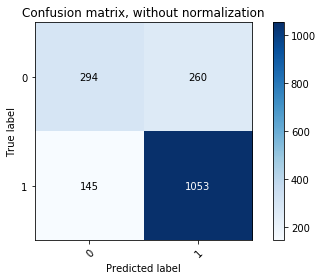

In [87]:
plot_confusion_matrix(test_true, test_pred, classes=[0, 1])

# Buscando los mejores hiperparámetros para precision

Mejores parámetros (por cross-validation):

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.77 (+/-0.06) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.76 (+/-0.05) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.76 (+/-0.07) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.76 (+/-0.05) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.76 (+/-0.05) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.74 (+/-0.05) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.77 (+/-0.05) for {'C': 1, 'degree': 3, 'kernel': 'poly'}
0.76 (+/-0.06) for {'C': 1, 'degree': 4, 'kernel': 'poly'}
0.76 (+/-0.06) for {'C': 1, 'degree': 5, 'kernel': 'poly'}
0.77 (+/-0.05) for {'C': 100, 'degree': 3, 'kernel': 'poly'}
0.75 (+/-0.07) for {'C': 100, 'degree': 4, 'kernel': 'poly'}
0.75 (+/-0.07) for {'C': 100, 'degree': 5, 'kernel': 'poly'}
0.76 (+/-0.05) for {'C': 1, 'kernel': 'linear'}
0.76 (+/-0.05) for {'C': 10, 'kernel': 'linear'}
0.76 (

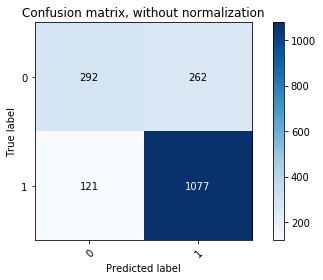

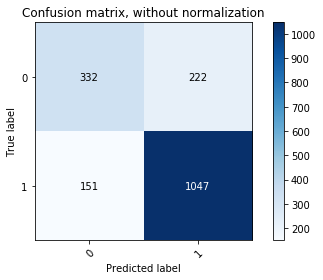

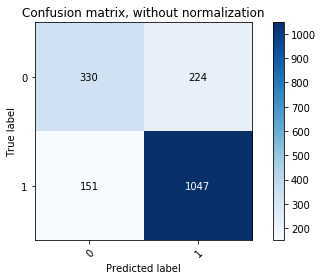

In [31]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-2, 1e-1],
                     'C': [1, 100]},
                    {'kernel': ['poly'], 'degree': [3,4,5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

scores = ['precision', 'recall', 'f1']

bests = {}

for score in scores:
    print("# Buscando los mejores hiperparámetros para %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)
    bests[score] = clf
    
    print("Mejores parámetros (por cross-validation):")
    print()
    print(clf.best_params_)
    print()
    print("Resultados para cada combinación:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.2f (+/-%0.02f) for %r"
              % (mean, std * 2, params))
    print()

    print("Resultados sobre conjunto de prueba:")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(y_true, y_pred, classes=[0,1])